In [1]:
# 1. Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, nltk

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, make_scorer, PrecisionRecallDisplay
)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Ensure reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)



True

In [3]:
# 2. Dataset Loading
df = pd.read_csv("spam.csv", encoding='latin-1', usecols=[0, 1], names=["label", "message"], skiprows=1)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("Dataset Shape:", df.shape)
print("Class Distribution:\n", df['label'].value_counts())

Dataset Shape: (5572, 2)
Class Distribution:
 label
0    4825
1     747
Name: count, dtype: int64


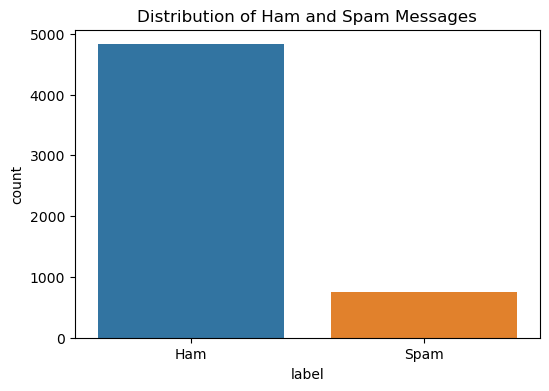

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


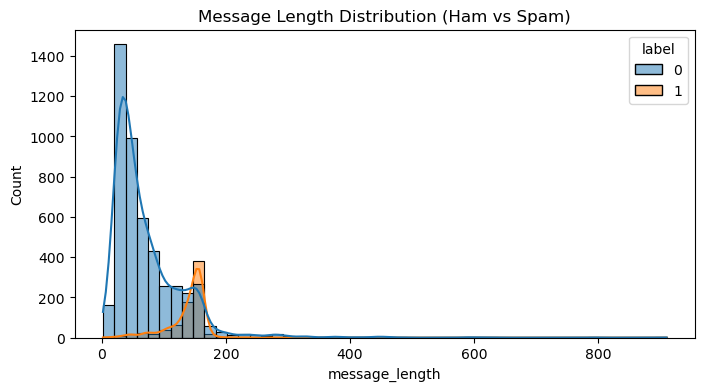

In [4]:
# 3. EDA & Visualizations
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title("Distribution of Ham and Spam Messages")
plt.xticks([0,1], ['Ham', 'Spam'])
plt.show()

df['message_length'] = df['message'].apply(len)
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Message Length Distribution (Ham vs Spam)")
plt.show()

In [5]:
# 4. Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text, use_stemming=False):
    text = text.lower()
    # Keep punctuation/symbols as features
    tokens = re.findall(r"[A-Za-z0-9£$!?.]+", text)
    if use_stemming:
        tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    else:
        tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_message'] = df['message'].apply(preprocess_text)

In [6]:
# 5. Feature Extraction
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_message'])
y = df['label']

In [7]:
# 6. Models
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(class_weight='balanced', random_state=RANDOM_STATE),
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)
}

# 7. Cross-Validation Evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = {}
for name, model in models.items():
    cv_scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    results[name] = {metric: f"{cv_scores['test_' + metric].mean():.4f} ± {cv_scores['test_' + metric].std():.4f}"
                     for metric in scoring.keys()}

summary = pd.DataFrame(results).T
print("\n📊 Cross-Validation Results (mean ± std over 5 folds):\n")
print(summary)


📊 Cross-Validation Results (mean ± std over 5 folds):

                            accuracy        precision           recall  \
Naive Bayes          0.9684 ± 0.0031  1.0000 ± 0.0000  0.7644 ± 0.0233   
SVM                  0.9831 ± 0.0046  0.9697 ± 0.0110  0.9022 ± 0.0291   
Logistic Regression  0.9770 ± 0.0049  0.9203 ± 0.0209  0.9076 ± 0.0287   

                                  f1  
Naive Bayes          0.8662 ± 0.0149  
SVM                  0.9346 ± 0.0191  
Logistic Regression  0.9136 ± 0.0192  


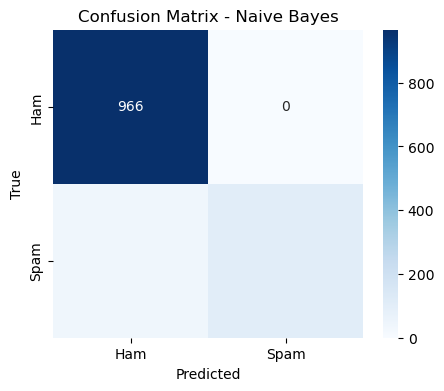


📋 Classification Report - Naive Bayes:
               precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       1.00      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115



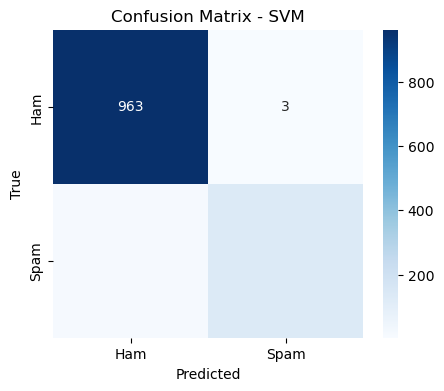


📋 Classification Report - SVM:
               precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.98      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



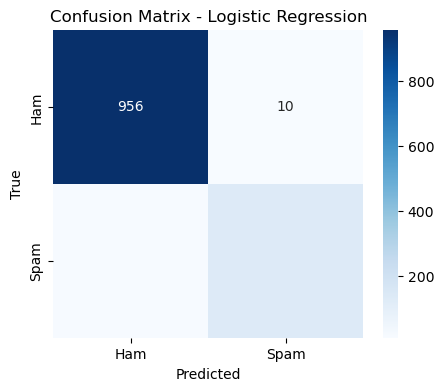


📋 Classification Report - Logistic Regression:
               precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       966
        Spam       0.93      0.90      0.91       149

    accuracy                           0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [8]:
# 8. Train-Test Split for Final Confusion Matrices
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

metrics_table = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics_table.append([name, acc, prec, rec, f1])
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"\n📋 Classification Report - {name}:\n", classification_report(y_test, y_pred, target_names=['Ham','Spam']))


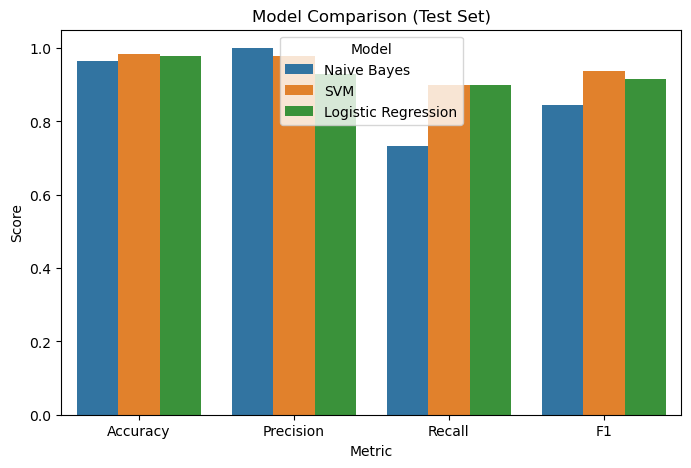

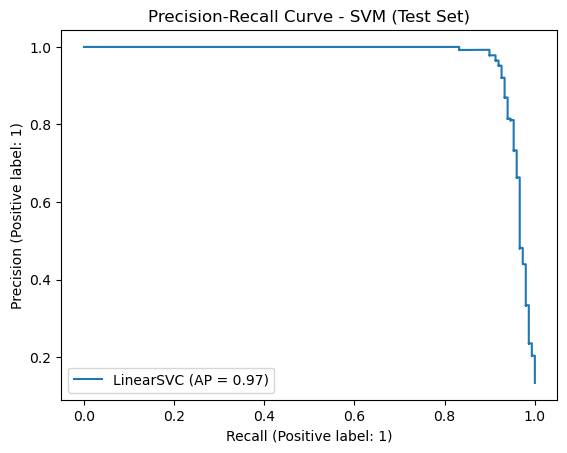

In [9]:
# 9. Comparison Plot
metrics_df = pd.DataFrame(metrics_table, columns=['Model','Accuracy','Precision','Recall','F1'])
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(8,5))
sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Model')
plt.title("Model Comparison (Test Set)")
plt.ylim(0,1.05)
plt.show()

# 10. Precision-Recall Curve for Best Model (SVM)
best_model = LinearSVC(class_weight='balanced', random_state=RANDOM_STATE)
best_model.fit(X_train, y_train)
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, pos_label=1)
plt.title("Precision-Recall Curve - SVM (Test Set)")
plt.show()

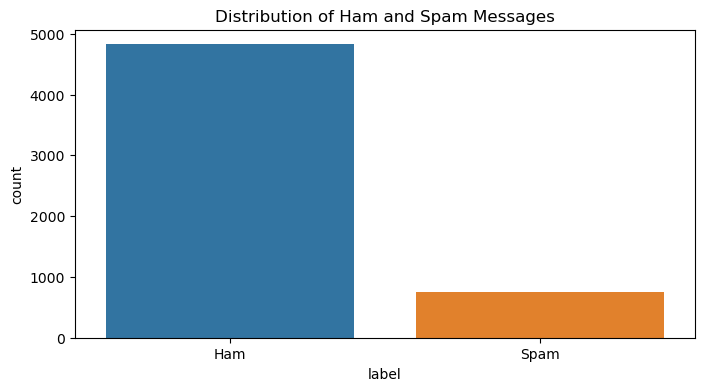

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


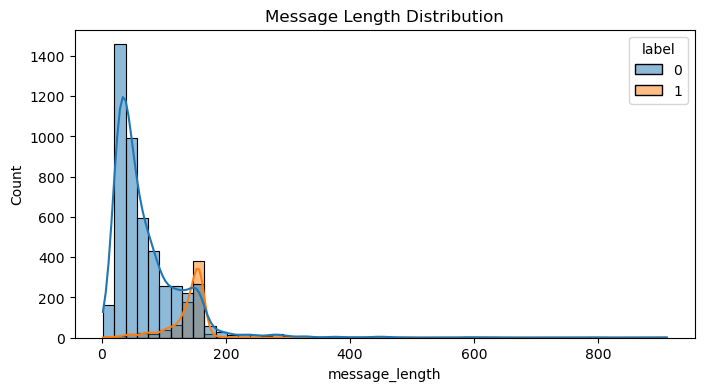

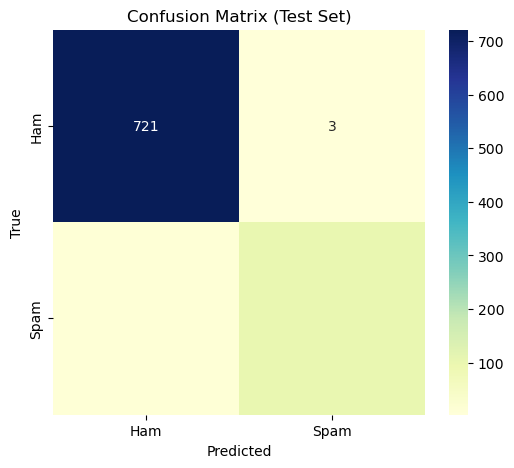

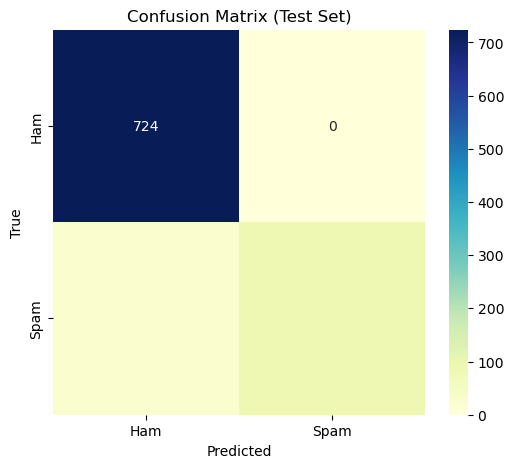

In [11]:
# ==========================
# 📧 Spam Classifier GUI (Fixed Prediction Output)
# ==========================

import tkinter as tk
from tkinter import filedialog, ttk, messagebox
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# --------------------------
# Global variables
# --------------------------
df = None
vectorizer = None
best_model = None
X_test, y_test = None, None

# --------------------------
# NLTK setup
# --------------------------
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text, use_stemming=False):
    """
    Preprocess text: lowercase, keep punctuation/symbols,
    optional stemming vs lemmatization.
    """
    text = text.lower()
    tokens = re.findall(r"[A-Za-z0-9£$!?.]+", text)
    if use_stemming:
        tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    else:
        tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

# --------------------------
# GUI setup
# --------------------------
root = tk.Tk()
root.title("📧 Spam Message Classifier")
root.geometry("1000x700")
root.configure(bg="#f0f8ff")

title_label = tk.Label(root, text="Spam SMS Classifier", font=("Arial", 24, "bold"), bg="#4682b4", fg="white")
title_label.pack(pady=10, fill='x')

frame = tk.Frame(root, bg="#f0f8ff")
frame.pack(pady=10)

# Output text box
text_box = tk.Text(root, height=12, width=120, bg="#fffff0")
text_box.pack(pady=10)

# --------------------------
# Functions
# --------------------------

def load_dataset():
    global df
    file_path = filedialog.askopenfilename()
    if not file_path:
        return
    df = pd.read_csv(file_path, encoding='latin-1', usecols=[0, 1], names=["label", "message"], skiprows=1)
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    text_box.insert(tk.END, f"✅ Dataset loaded with {len(df)} messages\n")

def perform_eda():
    if df is None:
        messagebox.showerror("Error", "Please load a dataset first!")
        return
    
    df['message_length'] = df['message'].apply(len)

    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x='label')
    plt.xticks([0,1], ['Ham','Spam'])
    plt.title("Distribution of Ham and Spam Messages")
    plt.show()

    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
    plt.title("Message Length Distribution")
    plt.show()

def train_model():
    global vectorizer, best_model, X_test, y_test

    if df is None:
        messagebox.showerror("Error", "Load dataset first.")
        return

    # Preprocess
    df['clean_message'] = df['message'].apply(preprocess_text)

    # TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['clean_message'])
    y = df['label']

    # Stratified split
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    # Choose model
    selected_model = model_var.get()
    if selected_model == "Naive Bayes":
        model = MultinomialNB()
    elif selected_model == "SVM":
        model = LinearSVC(class_weight='balanced', random_state=42)
    elif selected_model == "Logistic Regression":
        model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)

    # Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    best_model = model

    text_box.insert(tk.END, f"\n✅ Model: {selected_model}\n")
    text_box.insert(tk.END, f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}\n")

def evaluate_model():
    global best_model, X_test, y_test
    if best_model is None:
        messagebox.showerror("Error", "Train a model first.")
        return
    
    predictions = best_model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def predict_manual():
    global best_model, vectorizer
    msg = input_text.get()
    if not msg:
        messagebox.showerror("Error", "Enter a message to predict.")
        return
    if best_model is None or vectorizer is None:
        messagebox.showerror("Error", "Train the model first.")
        return

    # Clean & predict
    cleaned = preprocess_text(msg)
    vect_msg = vectorizer.transform([cleaned])
    pred = best_model.predict(vect_msg)[0]
    
    if pred == 1:
        label = "Spam 🚫"
        messagebox.showwarning("Prediction Result", f"This message is classified as: {label}")
    else:
        label = "Ham ✅"
        messagebox.showinfo("Prediction Result", f"This message is classified as: {label}")

    # Show in text box as well
    text_box.insert(tk.END, f"\n📩 Message: {msg}\nPrediction: {label}\n")

# --------------------------
# Widgets
# --------------------------
upload_button = tk.Button(frame, text="📂 Load Dataset", command=load_dataset, bg="#20b2aa", fg="white", font=("Arial", 12, "bold"))
upload_button.grid(row=0, column=0, padx=10)

eda_button = tk.Button(frame, text="📊 Show EDA", command=perform_eda, bg="#f08080", fg="white", font=("Arial", 12, "bold"))
eda_button.grid(row=0, column=1, padx=10)

model_var = tk.StringVar()
model_var.set("SVM")
model_menu = ttk.Combobox(frame, textvariable=model_var, values=["SVM", "Naive Bayes", "Logistic Regression"], width=20)
model_menu.grid(row=0, column=2, padx=10)

train_button = tk.Button(frame, text="⚙️ Train Model", command=train_model, bg="#6a5acd", fg="white", font=("Arial", 12, "bold"))
train_button.grid(row=0, column=3, padx=10)

eval_button = tk.Button(frame, text="📈 Evaluate Model", command=evaluate_model, bg="#ffa500", fg="white", font=("Arial", 12, "bold"))
eval_button.grid(row=0, column=4, padx=10)

# Manual Prediction
input_frame = tk.Frame(root, bg="#f0f8ff")
input_frame.pack(pady=10)

input_label = tk.Label(input_frame, text="Enter a message:", font=("Arial", 12, "bold"), bg="#f0f8ff")
input_label.pack(side=tk.LEFT)

input_text = tk.Entry(input_frame, width=80, font=("Arial", 12))
input_text.pack(side=tk.LEFT, padx=10)

predict_button = tk.Button(input_frame, text="🔍 Predict", command=predict_manual, bg="#228b22", fg="white", font=("Arial", 12, "bold"))
predict_button.pack(side=tk.LEFT)

# --------------------------
# Run GUI
# --------------------------
root.mainloop()
